## Necessary Library Installations and Imports

Folktables - Python library that allows us to access US Census Datasets for different states that consists of mulltiple sensitive attributes. <br>
Polars - Python Data Manipulation and Handling library. Similar to Pandas

In [3]:
# !pip install folktables
# !pip install polars
# ! pip install xgboost
# !pip install lightgbm

In [31]:
import folktables
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from folktables import ACSDataSource, ACSIncome, ACSPublicCoverage, generate_categories
import matplotlib.colors as mcolors
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,BaggingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from fairlearn.reductions import ExponentiatedGradient, GridSearch
from fairlearn.metrics import demographic_parity_difference
from sklearn.base import clone
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

<p> Data is being loaded through the <b>folk-tables</b> module. We are going to perform our Fairness Metrics Analysis on the <b style="color:green;">Public Health Coverage</b> Data from the US Census 2018 of 5 different US states </p>

<p style="font-size:small;">Downloading in the following cell takes longer to run,the dataset has been downloaded and saved as CSV files and commented out. </p>

In [5]:
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')

# ca_data = data_source.get_data(states=["CA","MA","TX", "NY", "GA"], download=True)
# print(list(ca_data.head().columns))

# ca_features, ca_labels, _ = ACSPublicCoverage.df_to_pandas(ca_data)
# ca_features.to_csv('data/multi_state_features.csv', index=False)
# ca_labels.to_csv('data/multi_state_labels.csv', index=False)

# Commented because already ran once and saved the CSV files

<p style="font-size:small;">Column definitions can be accessed through the get definitions method in the data_source. Also, generate_categories specifies the column names available in the dataset.</p>

In [6]:
definition_df = data_source.get_definitions(download=True)
categories = generate_categories(features=ACSPublicCoverage.features, definition_df=definition_df)

In [7]:
categories.keys()

dict_keys(['SCHL', 'MAR', 'SEX', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'ESR', 'ST', 'FER', 'RAC1P'])

In [8]:
features = pl.read_csv('data/multi_state_features.csv')
labels = pl.read_csv("data/multi_state_labels.csv")

In [9]:
features.shape,labels.shape

((364726, 19), (364726, 1))

<p style="font-size:medium;">The dataset consists of <b>more than 300k rows with 19 columns</b>, excluding the label column.</p>

In [10]:
features.describe()

statistic,AGEP,SCHL,MAR,SEX,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,PINCP,ESR,ST,FER,RAC1P
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",364726.0,364726.0,364726.0,364726.0,364726.0,364726.0,364726.0,364726.0,364726.0,364726.0,364726.0,364726.0,364726.0,364726.0,364726.0,364726.0,364726.0,364726.0,364726.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",35.933569,16.554655,3.346452,1.565156,1.865258,0.300036,1.89032,1.325938,3.658231,1.76107,1.239635,1.980813,1.9744,1.931077,9577.727653,3.353663,24.817581,0.80549,2.630556
"""std""",15.550484,4.126389,1.864167,0.495737,0.341449,1.217979,1.550974,0.731327,1.067738,1.129982,0.426861,0.137182,0.157939,0.253323,9969.563992,2.455723,17.82939,0.970503,2.692612
"""min""",15.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,-8300.0,0.0,6.0,0.0,1.0
"""25%""",21.0,15.0,1.0,1.0,2.0,0.0,1.0,1.0,4.0,1.0,1.0,2.0,2.0,2.0,0.0,1.0,6.0,0.0,1.0
"""50%""",33.0,17.0,5.0,2.0,2.0,0.0,1.0,1.0,4.0,1.0,1.0,2.0,2.0,2.0,6600.0,3.0,25.0,0.0,1.0
"""75%""",50.0,19.0,5.0,2.0,2.0,0.0,3.0,1.0,4.0,2.0,1.0,2.0,2.0,2.0,18000.0,6.0,48.0,2.0,2.0
"""max""",64.0,24.0,5.0,2.0,2.0,8.0,5.0,3.0,4.0,4.0,2.0,2.0,2.0,2.0,30000.0,6.0,48.0,2.0,9.0


<p style="font-size:medium;">This code uses the column definitions and aggregates them into a single data-structure to access the unique possible values and the definitions of the individual columns available in the dataset.</p>

In [11]:
column_details = {}
for col in features.columns:
    print(col,"---",definition_df[definition_df[1]==col].values[0][4])
    d  = {}
    d['Definition'] = definition_df[definition_df[1]==col].values[0][4]
    d['Possible Values'] = [col[6] for col in (definition_df[definition_df[1]==col].values.tolist()[1:])]
    column_details[col]=d    


AGEP --- Age
SCHL --- Educational attainment
MAR --- Marital status
SEX --- Sex
DIS --- Disability recode
ESP --- Employment status of parents
CIT --- Citizenship status
MIG --- Mobility status (lived here 1 year ago)
MIL --- Military service
ANC --- Ancestry recode
NATIVITY --- Nativity
DEAR --- Hearing difficulty
DEYE --- Vision difficulty
DREM --- Cognitive difficulty
PINCP --- Total person's income (signed, use ADJINC to adjust to constant dollars)
ESR --- Employment status recode
ST --- State Code based on 2010 Census definitions
FER --- Gave birth to child within the past 12 months
RAC1P --- Recoded detailed race code


<p>Among all the possible sensitive attributes, we are considering <b style="color:green">SEX, DIS, MAR, RAC1P</b> as our sensitive attributes in the dataset for the analysis.</p>

In [12]:
column_details['RAC1P']

{'Definition': 'Recoded detailed race code',
 'Possible Values': ['White alone',
  'Black or African American alone',
  'American Indian alone',
  'Alaska Native alone',
  'American Indian and Alaska Native tribes specified; or American Indian or Alaska Native, not specified and no other races',
  'Asian alone',
  'Native Hawaiian and Other Pacific Islander alone',
  'Some Other Race alone',
  'Two or More Races']}

In [13]:
colors = np.random.choice(list(mcolors.CSS4_COLORS.keys()),size=4)
colors

array(['indianred', 'lavenderblush', 'slategrey', 'darkgoldenrod'],
      dtype='<U20')

<p>Histogram Visualization of the sensitive attributes in the dataset.</p>

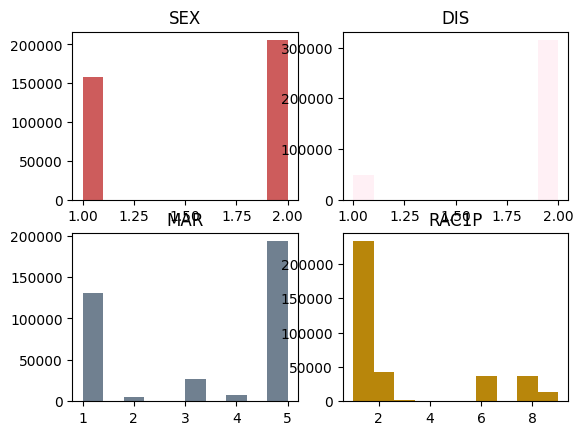

<Figure size 1200x1200 with 0 Axes>

In [14]:
i = 0
used = {}
a=0
b=0
fig,ax = plt.subplots(2,2)
plt.figure(figsize=(12,12))
for col in ['SEX','DIS','MAR','RAC1P']:
    ax[a,b].hist(features[col],color=colors[i])
    ax[a,b].set_title(col)
    used[col]=colors[i]
    i+=1
    b+=1
    if b==2:
        a=1
        b=0
plt.show()

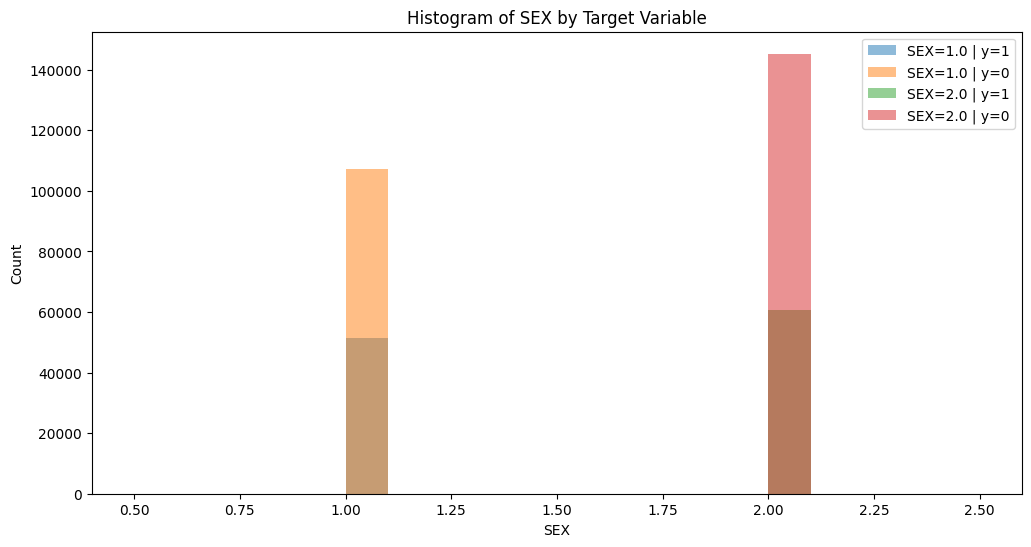

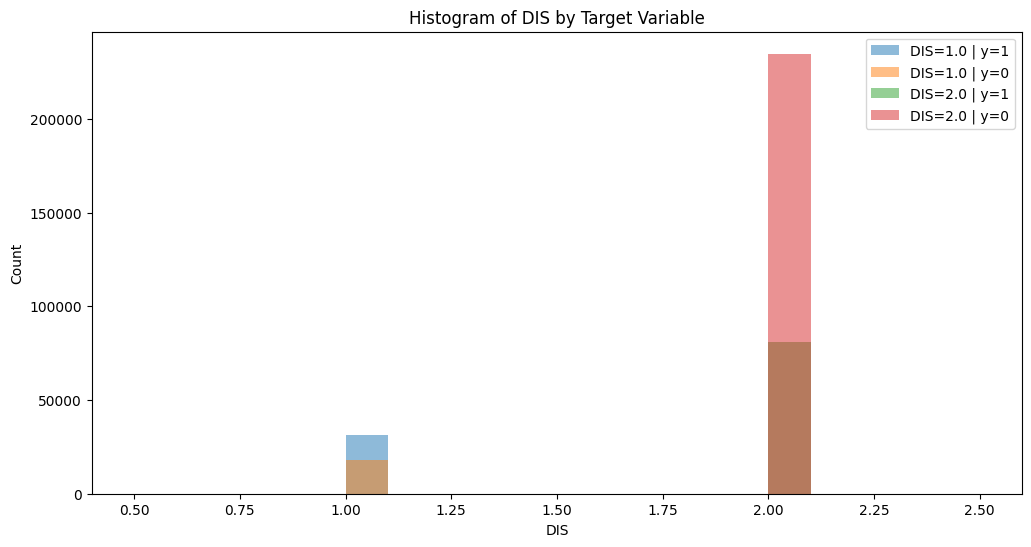

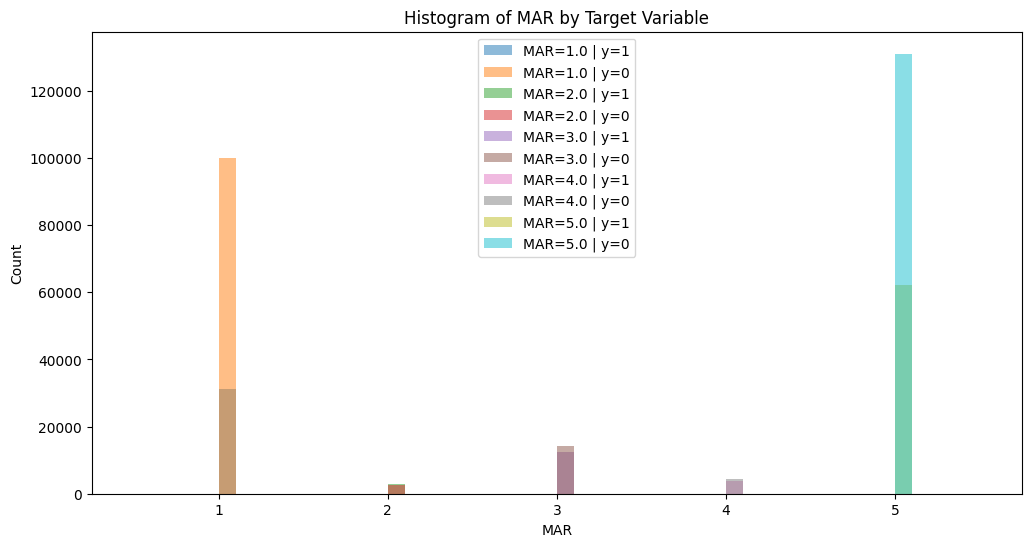

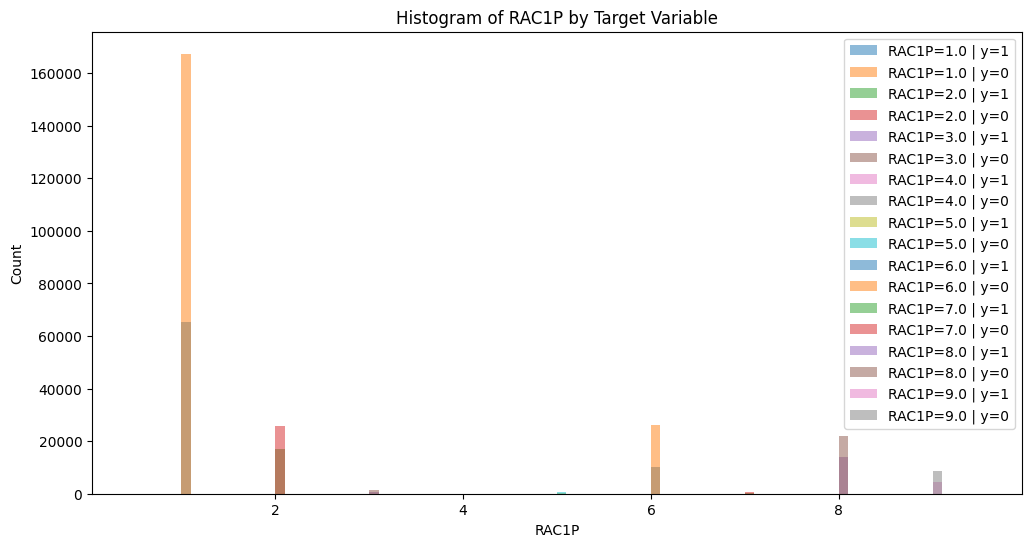

In [15]:
sensitive_attributes = ['SEX', 'DIS', 'MAR', 'RAC1P']

data = features.clone()
data = data.with_columns(label = labels['PUBCOV']._recursive_cast_to_dtype(int))

def plot_histograms(data, sensitive_attributes, target_col='label'):

    for attr in sensitive_attributes:
        unique_groups = data[attr].unique()
        plt.figure(figsize=(12, 6))
        for group in unique_groups:
            plt.hist(data.filter((pl.col(attr) == group) & (pl.col(target_col) == 1))[attr], alpha=0.5, label=f"{attr}={group} | y=1")
            plt.hist(data.filter((pl.col(attr) == group )& (pl.col(target_col) == 0))[attr], alpha=0.5, label=f"{attr}={group} | y=0")
        
        plt.title(f"Histogram of {attr} by Target Variable")
        plt.xlabel(attr)
        plt.ylabel("Count")
        plt.legend()
        plt.show()

plot_histograms(data, sensitive_attributes, target_col='label')


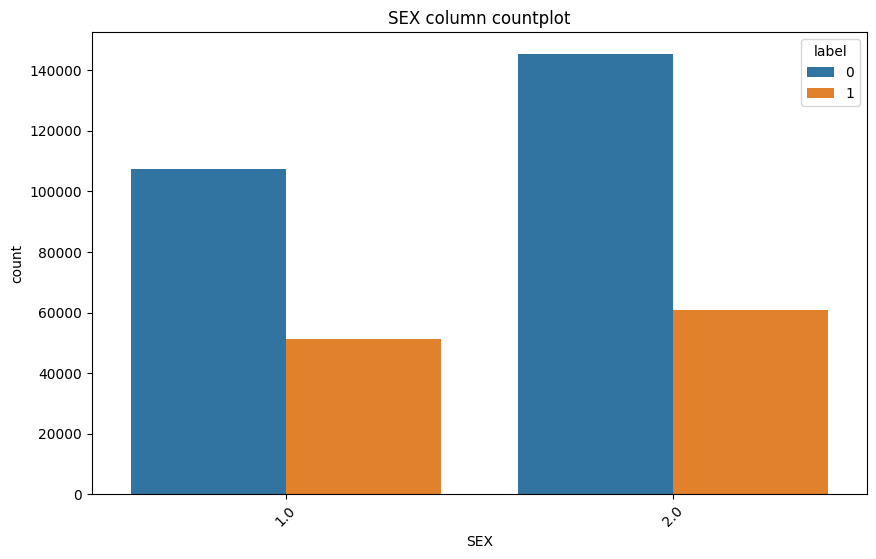

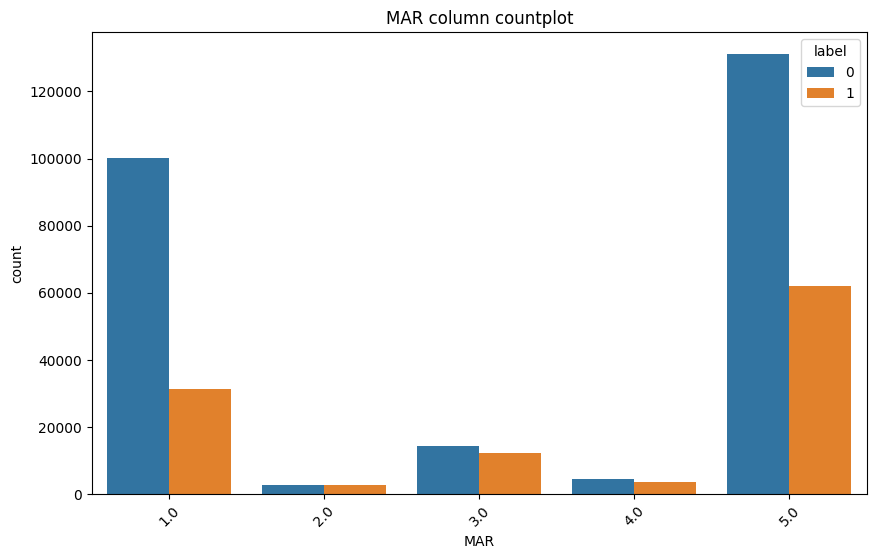

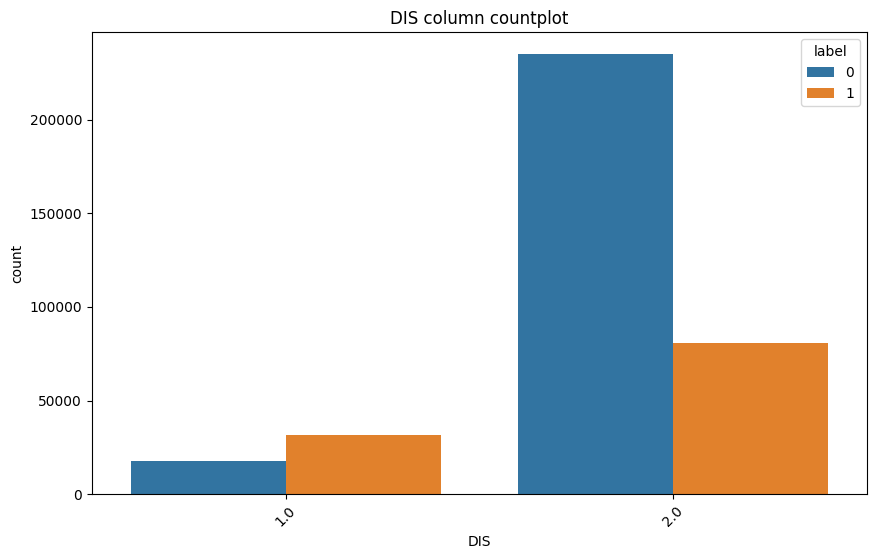

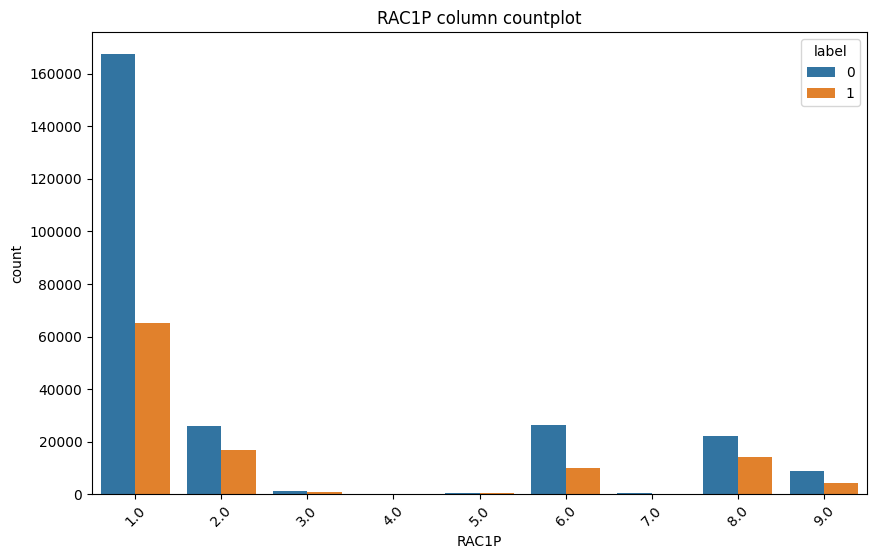

In [16]:
plt.figure(figsize=(10,6))
sns.countplot(data=data,hue='label',x='SEX')
plt.title("SEX column countplot")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10,6))
sns.countplot(data=data,hue='label',x='MAR')
plt.title("MAR column countplot")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10,6))
sns.countplot(data=data,hue='label',x='DIS')
plt.title("DIS column countplot")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10,6))
sns.countplot(data=data,hue='label',x='RAC1P')
plt.title("RAC1P column countplot")
plt.xticks(rotation=45)
plt.show()



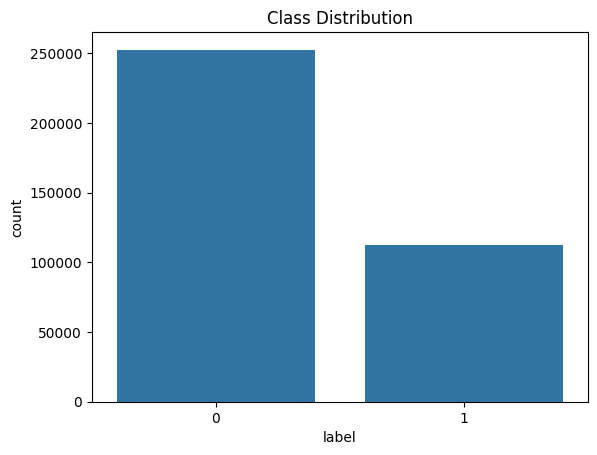

In [17]:
sns.countplot(x='label', data=data)
plt.title("Class Distribution")
plt.show()

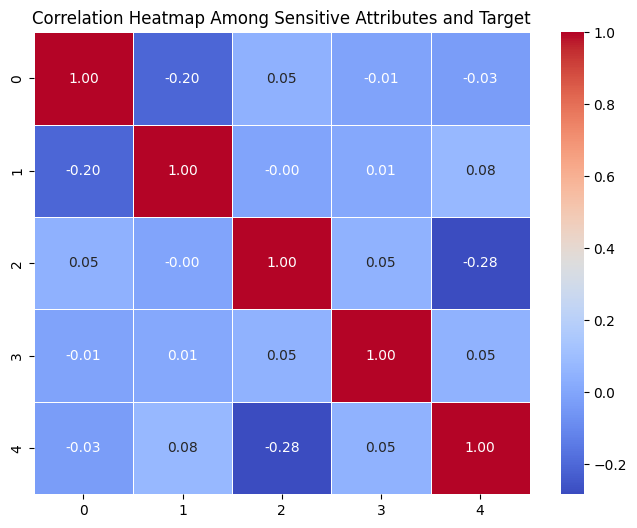

In [18]:
correlation_matrix = data['SEX','MAR','DIS','RAC1P','label'].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap Among Sensitive Attributes and Target")
plt.show()

In [19]:
print("\nSummary Statistics:")
print(data.describe())

numerical_cols = data.select(pl.selectors.numeric()).columns 
numerical_cols.remove('label')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
    ]
)

X = data.drop(['label'])
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


Summary Statistics:
shape: (9, 21)
┌────────────┬───────────┬───────────┬──────────┬───┬───────────┬──────────┬──────────┬──────────┐
│ statistic  ┆ AGEP      ┆ SCHL      ┆ MAR      ┆ … ┆ ST        ┆ FER      ┆ RAC1P    ┆ label    │
│ ---        ┆ ---       ┆ ---       ┆ ---      ┆   ┆ ---       ┆ ---      ┆ ---      ┆ ---      │
│ str        ┆ f64       ┆ f64       ┆ f64      ┆   ┆ f64       ┆ f64      ┆ f64      ┆ f64      │
╞════════════╪═══════════╪═══════════╪══════════╪═══╪═══════════╪══════════╪══════════╪══════════╡
│ count      ┆ 364726.0  ┆ 364726.0  ┆ 364726.0 ┆ … ┆ 364726.0  ┆ 364726.0 ┆ 364726.0 ┆ 364726.0 │
│ null_count ┆ 0.0       ┆ 0.0       ┆ 0.0      ┆ … ┆ 0.0       ┆ 0.0      ┆ 0.0      ┆ 0.0      │
│ mean       ┆ 35.933569 ┆ 16.554655 ┆ 3.346452 ┆ … ┆ 24.817581 ┆ 0.80549  ┆ 2.630556 ┆ 0.307538 │
│ std        ┆ 15.550484 ┆ 4.126389  ┆ 1.864167 ┆ … ┆ 17.82939  ┆ 0.970503 ┆ 2.692612 ┆ 0.461475 │
│ min        ┆ 15.0      ┆ 1.0       ┆ 1.0      ┆ … ┆ 6.0       ┆ 0.0    

In [20]:

model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

model_pipeline.fit(X_train, y_train)

y_pred = model_pipeline.predict(X_test)
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Model Accuracy: 0.7396430236065035
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.93      0.83     50512
           1       0.67      0.31      0.42     22434

    accuracy                           0.74     72946
   macro avg       0.71      0.62      0.63     72946
weighted avg       0.73      0.74      0.71     72946



In [21]:
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

model_pipeline.fit(X_train, y_train)

y_pred = model_pipeline.predict(X_test)
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Model Accuracy: 0.7718449263839005
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.88      0.84     50512
           1       0.66      0.52      0.58     22434

    accuracy                           0.77     72946
   macro avg       0.74      0.70      0.71     72946
weighted avg       0.76      0.77      0.76     72946



In [22]:

def compute_fairness_metrics(y_true, y_pred, sensitive_attr):
    unique_groups = np.unique(sensitive_attr)
    results = {}
    
    for group in unique_groups:
        idx = (sensitive_attr == group)
        y_true_g = y_true[idx]
        y_pred_g = y_pred[idx]
        tn, fp, fn, tp = confusion_matrix(y_true_g, y_pred_g).ravel()
        
        TPR = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
        FPR = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate
        PPV = tp / (tp + fp) if (tp + fp) > 0 else 0  # Positive Predictive Value (Precision)
        NPV = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value
        
        results[group] = {
            "Demographic Parity": np.mean(y_pred_g),
            "Accuracy": accuracy_score(y_true_g, y_pred_g),
            "TPR": TPR,
            "FPR": FPR,
            "PPV": PPV,
            "NPV": NPV,
            "Disparate Mistreatment": abs((fp + fn) / len(y_true_g)),  # Error Rate Disparity
            "Equalized Odds": abs(TPR - FPR)  # Equalized Odds Calculation
        }
    
    return results


compute_fairness_metrics(y_test.to_pandas(),y_pred,X_test['DIS'])


{np.float64(1.0): {'Demographic Parity': np.float64(0.6674829099071523),
  'Accuracy': 0.7971635547393123,
  'TPR': np.float64(0.8630420918367347),
  'FPR': np.float64(0.3199206574100312),
  'PPV': np.float64(0.8274228064811984),
  'NPV': np.float64(0.7364222154034981),
  'Disparate Mistreatment': np.float64(0.2028364452606877),
  'Equalized Odds': np.float64(0.5431214344267036)},
 np.float64(2.0): {'Demographic Parity': np.float64(0.1745031277219099),
  'Accuracy': 0.7679151160028506,
  'TPR': np.float64(0.3875139215443633),
  'FPR': np.float64(0.1012281037822191),
  'PPV': np.float64(0.5683818858335602),
  'NPV': np.float64(0.8100947703641177),
  'Disparate Mistreatment': np.float64(0.2320848839971494),
  'Equalized Odds': np.float64(0.28628581776214423)}}

In [23]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

def compute_fairness_metrics(y_true, y_pred, sensitive_attr):
    unique_groups = np.unique(sensitive_attr)
    results = {}
    
    parity_values = {
        "Demographic Parity": [],
        "TPR": [],
        "FPR": [],
        "PPV": [],
        "NPV": [],
        "Disparate Mistreatment": [],
        "Equalized Odds": []
    }
    
    for group in unique_groups:
        idx = (sensitive_attr == group)
        y_true_g = y_true[idx]
        y_pred_g = y_pred[idx]
        tn, fp, fn, tp = confusion_matrix(y_true_g, y_pred_g).ravel()
        
        TPR = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
        FPR = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate
        PPV = tp / (tp + fp) if (tp + fp) > 0 else 0  # Positive Predictive Value (Precision)
        NPV = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value
        Disparate_Mistreatment = abs((fp + fn) / len(y_true_g))  # Error Rate Disparity
        Equalized_Odds = abs(TPR - FPR)  # Equalized Odds Calculation
        Demographic_Parity = np.mean(y_pred_g)

        parity_values["Demographic Parity"].append(Demographic_Parity)
        parity_values["TPR"].append(TPR)
        parity_values["FPR"].append(FPR)
        parity_values["PPV"].append(PPV)
        parity_values["NPV"].append(NPV)
        parity_values["Disparate Mistreatment"].append(Disparate_Mistreatment)
        parity_values["Equalized Odds"].append(Equalized_Odds)

        results[group] = {
            "Demographic Parity": Demographic_Parity,
            "Accuracy": accuracy_score(y_true_g, y_pred_g),
            "TPR": TPR,
            "FPR": FPR,
            "PPV": PPV,
            "NPV": NPV,
            "Disparate Mistreatment": Disparate_Mistreatment,
            "Equalized Odds": Equalized_Odds
        }

    fairness_differences = {
        "Demographic Parity Difference": max(parity_values["Demographic Parity"]) - min(parity_values["Demographic Parity"]),
        "TPR Difference": max(parity_values["TPR"]) - min(parity_values["TPR"]),
        "FPR Difference": max(parity_values["FPR"]) - min(parity_values["FPR"]),
        "PPV Difference": max(parity_values["PPV"]) - min(parity_values["PPV"]),
        "NPV Difference": max(parity_values["NPV"]) - min(parity_values["NPV"]),
        "Disparate Mistreatment Difference": max(parity_values["Disparate Mistreatment"]) - min(parity_values["Disparate Mistreatment"]),
        "Equalized Odds Difference": max(parity_values["Equalized Odds"]) - min(parity_values["Equalized Odds"])
    }

    return results, fairness_differences

group_metrics, fairness_diffs = compute_fairness_metrics(y_test.to_pandas(), y_pred, X_test['DIS'])

print("Group-wise Fairness Metrics:")
for group, metrics in group_metrics.items():
    print(f"Group {group}: {metrics}")

print("\nFairness Differences Across Groups:")
for metric, diff in fairness_diffs.items():
    print(f"{metric}: {diff:.4f}")


Group-wise Fairness Metrics:
Group 1.0: {'Demographic Parity': np.float64(0.6674829099071523), 'Accuracy': 0.7971635547393123, 'TPR': np.float64(0.8630420918367347), 'FPR': np.float64(0.3199206574100312), 'PPV': np.float64(0.8274228064811984), 'NPV': np.float64(0.7364222154034981), 'Disparate Mistreatment': np.float64(0.2028364452606877), 'Equalized Odds': np.float64(0.5431214344267036)}
Group 2.0: {'Demographic Parity': np.float64(0.1745031277219099), 'Accuracy': 0.7679151160028506, 'TPR': np.float64(0.3875139215443633), 'FPR': np.float64(0.1012281037822191), 'PPV': np.float64(0.5683818858335602), 'NPV': np.float64(0.8100947703641177), 'Disparate Mistreatment': np.float64(0.2320848839971494), 'Equalized Odds': np.float64(0.28628581776214423)}

Fairness Differences Across Groups:
Demographic Parity Difference: 0.4930
TPR Difference: 0.4755
FPR Difference: 0.2187
PPV Difference: 0.2590
NPV Difference: 0.0737
Disparate Mistreatment Difference: 0.0292
Equalized Odds Difference: 0.2568


In [24]:
from lightgbm import LGBMClassifier
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier())
])
model_pipeline.fit(X_train, y_train)

y_pred = model_pipeline.predict(X_test)
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
sensitive_features = ['DIS', 'SEX', 'MAR', 'RAC1P']
for s in sensitive_features:   
    print(s)
    print(compute_fairness_metrics(y_test.to_pandas(),y_pred,X_test[s]))
    print()

[LightGBM] [Info] Number of positive: 89733, number of negative: 202047
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 414
[LightGBM] [Info] Number of data points in the train set: 291780, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.307537 -> initscore=-0.811662
[LightGBM] [Info] Start training from score -0.811662


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Model Accuracy: 0.7828119430811833
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.92      0.85     50512
           1       0.73      0.47      0.57     22434

    accuracy                           0.78     72946
   macro avg       0.76      0.70      0.71     72946
weighted avg       0.78      0.78      0.77     72946

DIS
({np.float64(1.0): {'Demographic Parity': np.float64(0.6774818896031017), 'Accuracy': 0.7953270074482196, 'TPR': np.float64(0.8694196428571429), 'FPR': np.float64(0.33635590818928873), 'PPV': np.float64(0.8212349397590362), 'NPV': np.float64(0.7409047769693136), 'Disparate Mistreatment': np.float64(0.20467299255178042), 'Equalized Odds': np.float64(0.5330637346678542)}, np.float64(2.0): {'Demographic Parity': np.float64(0.126296618893024), 'Accuracy': 0.7808694275081163, 'TPR': np.float64(0.31864868209380026), 'FPR': np.float64(0.060128131451801715), 'PPV': np.float64(0.64576802507837), 'NPV': np.float6

In [ ]:
def perform_dataset_intervention(dataset):
    np.random.seed(23)

    numerical_cols = dataset.select(pl.selectors.numeric()).columns 
    numerical_cols.remove('label')

    X = dataset.drop(['label'])
    y = dataset['label']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    rf_model = RandomForestClassifier(random_state=42)
    xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
    lgbm_model = LGBMClassifier(random_state=42)
    all_models = [LogisticRegression(),GaussianNB(),SVC(max_iter=1000),DecisionTreeClassifier(),rf_model,xgb_model,
                  lgbm_model,VotingClassifier(estimators=[
        ('Random Forest', rf_model),
        ('XGBoost', xgb_model),
        ('LightGBM', lgbm_model)
    ], voting='soft')]
    
    Model_Results = {}

    for model in all_models:
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numerical_cols),
            ]
        )
        model_pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])

        model_pipeline.fit(X_train, y_train)

        y_pred = model_pipeline.predict(X_test)
        group_metrics, fairness_diffs = compute_fairness_metrics(y_test.to_pandas(), y_pred, X_test['DIS'])
        report = classification_report(y_test.to_pandas(), y_pred)
        Model_Results[str(model)] = {'Classification Report':report,'Group Metrics':group_metrics,'Fairness':fairness_diffs}
        print("Model : ",str(model))
        print("Classification Report :",report)
        print("Fairness Differences :",fairness_diffs)
        print()
        print()
    return Model_Results

In [28]:
perform_dataset_intervention(data)

Model :  LogisticRegression()
Classification Report :               precision    recall  f1-score   support

           0       0.75      0.93      0.83     50512
           1       0.67      0.31      0.42     22434

    accuracy                           0.74     72946
   macro avg       0.71      0.62      0.63     72946
weighted avg       0.73      0.74      0.71     72946

Fairness Differences : {'Demographic Parity Difference': np.float64(0.7816821612064404), 'TPR Difference': np.float64(0.8259097460912345), 'FPR Difference': np.float64(0.6469695811970407), 'PPV Difference': np.float64(0.1716104375379971), 'NPV Difference': np.float64(0.10158864576081783), 'Disparate Mistreatment Difference': np.float64(0.05082910307873534), 'Equalized Odds Difference': np.float64(0.17894016489419376)}
Model :  GaussianNB()
Classification Report :               precision    recall  f1-score   support

           0       0.75      0.91      0.82     50512
           1       0.61      0.33      0.4

/home/codespace/.local/lib/python3.12/site-packages/sklearn/svm/_base.py:304: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Model :  SVC(max_iter=1000)
Classification Report :               precision    recall  f1-score   support

           0       0.69      0.95      0.80     50512
           1       0.28      0.04      0.07     22434

    accuracy                           0.67     72946
   macro avg       0.49      0.50      0.44     72946
weighted avg       0.56      0.67      0.58     72946

Fairness Differences : {'Demographic Parity Difference': np.float64(0.05402034333905904), 'TPR Difference': np.float64(0.05899165638597971), 'FPR Difference': np.float64(0.052246271987093695), 'PPV Difference': np.float64(0.22079439252336447), 'NPV Difference': np.float64(0.3853459577613171), 'Disparate Mistreatment Difference': np.float64(0.3600392218805347), 'Equalized Odds Difference': np.float64(0.006497529164414779)}
Model :  DecisionTreeClassifier()
Classification Report :               precision    recall  f1-score   support

           0       0.80      0.81      0.80     50512
           1       0.55     

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:46:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model :  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)
Classification Report :               precision    recall  f1-score   support

           0       0.80      0.92      0.86     50512
           1       0.72      0.49      0.59     22434

    accuracy                           0.

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Model :  LGBMClassifier(random_state=42)
Classification Report :               precision    recall  f1-score   support

           0       0.80      0.92      0.85     50512
           1       0.72      0.47      0.57     22434

    accuracy                           0.78     72946
   macro avg       0.76      0.70      0.71     72946
weighted avg       0.77      0.78      0.77     72946

Fairness Differences : {'Demographic Parity Difference': np.float64(0.5537573110715254), 'TPR Difference': np.float64(0.5519799016779092), 'FPR Difference': np.float64(0.28341835802772863), 'PPV Difference': np.float64(0.17337821292217614), 'NPV Difference': np.float64(0.06248104713546143), 'Disparate Mistreatment Difference': np.float64(0.011769734382192004), 'Equalized Odds Difference': np.float64(0.26856154365018053)}


/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:47:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 89733, number of negative: 202047
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 414
[LightGBM] [Info] Number of data points in the train set: 291780, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.307537 -> initscore=-0.811662
[LightGBM] [Info] Start training from score -0.811662


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Model :  VotingClassifier(estimators=[('Random Forest',
                              RandomForestClassifier(random_state=42)),
                             ('XGBoost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='mlogloss',
                                            feature_types=None, gamma=None,
                                            grow_policy...
                                            interaction_constraints=None,
                                            learning_rate=None

{'LogisticRegression()': {'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.75      0.93      0.83     50512\n           1       0.67      0.31      0.42     22434\n\n    accuracy                           0.74     72946\n   macro avg       0.71      0.62      0.63     72946\nweighted avg       0.73      0.74      0.71     72946\n',
  'Group Metrics': {np.float64(1.0): {'Demographic Parity': np.float64(0.8177736965615754),
    'Accuracy': 0.6956433017039078,
    'TPR': np.float64(0.9011479591836735),
    'FPR': np.float64(0.6695947860583735),
    'PPV': np.float64(0.7051777916406737),
    'NPV': np.float64(0.6528555431131019),
    'Disparate Mistreatment': np.float64(0.30435669829609224),
    'Equalized Odds': np.float64(0.2315531731253)},
   np.float64(2.0): {'Demographic Parity': np.float64(0.036091535355135006),
    'Accuracy': 0.7464724047826431,
    'TPR': np.float64(0.07523821309243905),
    'FPR': np.float64(0.022625204861332

<p>Model Intervention</p>

In [40]:
import warnings
warnings.filterwarnings('ignore')

In [41]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from sklearn.pipeline import make_pipeline

def perform_model_intervention(dataset, selected_models=None, use_fairness_constraints=True):
    np.random.seed(42)

    numerical_cols = dataset.select(pl.selectors.numeric()).columns 
    numerical_cols.remove('label')

    X = dataset.drop(['label'])
    y = dataset['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    models_with_params = {
    LogisticRegression(): {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l1', 'l2']
    },
    DecisionTreeClassifier(random_state=42): {
        'max_depth': [5, 10, 20, None],  # Controls tree depth
        'min_samples_split': [2, 5, 10],  # Minimum samples required to split
        'min_samples_leaf': [1, 2, 5],  # Minimum samples in leaf node
        'criterion': ['gini', 'entropy'],  # Splitting criteria
        'max_features': [None, 'sqrt', 'log2']  # Number of features considered at each split
    },
    RandomForestClassifier(random_state=42): {
        'n_estimators': [50, 100, 200], 
        'max_depth': [5, 10, 20]
    },
    XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'): {
        'n_estimators': [50, 100], 
        'learning_rate': [0.01, 0.1]
    },
    LGBMClassifier(random_state=42): {
        'n_estimators': [50, 100], 
        'learning_rate': [0.01, 0.1]
    }
}


    if selected_models is not None:
        models_with_params = {k: v for k, v in models_with_params.items() if type(k) in selected_models}

    Model_Results = {}

    for model, param_grid in models_with_params.items():
        preprocessor = ColumnTransformer([('num', StandardScaler(), numerical_cols)])
        
        if param_grid:
            if isinstance(model, (RandomForestClassifier, XGBClassifier, LGBMClassifier)):
                search = RandomizedSearchCV(model, param_grid, scoring='accuracy', cv=3, n_jobs=-1, n_iter=10)
            else:
                search = GridSearchCV(model, param_grid, scoring='accuracy', cv=3, n_jobs=-1)
            search.fit(X_train, y_train)
            best_model = search.best_estimator_
        else:
            best_model = model.fit(X_train, y_train)

        if use_fairness_constraints:
            if isinstance(best_model, (LogisticRegression, RandomForestClassifier, XGBClassifier, LGBMClassifier)):
                fair_model = ExponentiatedGradient(best_model, constraints=DemographicParity())
                fair_model.fit(X_train, y_train, sensitive_features=X_train['DIS'])
                y_pred = fair_model.predict(X_test)
            else:
                print(f"Skipping fairness constraints for {str(model)} (does not support sample_weight).")
                y_pred = best_model.predict(X_test)
        else:
            y_pred = best_model.predict(X_test)

        group_metrics, fairness_diffs = compute_fairness_metrics(y_test.to_pandas(), y_pred, X_test['DIS'])
        report = classification_report(y_test.to_pandas(), y_pred)

        Model_Results[str(model)] = {
            'Best Parameters': search.best_params_ if param_grid else "No tuning",
            'Classification Report': report,
            'Group Metrics': group_metrics,
            'Fairness': fairness_diffs
        }

        print(f"Model: {str(model)}")
        print("Best Parameters:", Model_Results[str(model)]['Best Parameters'])
        print("Classification Report:\n", report)
        print("Fairness Differences:", fairness_diffs)
        print("\n" + "-"*80 + "\n")

    return Model_Results

# Example Usage:
results = perform_model_intervention(data, selected_models=[LogisticRegression, DecisionTreeClassifier, XGBClassifier], use_fairness_constraints=True)


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

Model: LogisticRegression()
Best Parameters: {'C': 1, 'penalty': 'l2'}
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.97      0.82     50512
           1       0.53      0.07      0.13     22434

    accuracy                           0.69     72946
   macro avg       0.62      0.52      0.47     72946
weighted avg       0.65      0.69      0.60     72946

Fairness Differences: {'Demographic Parity Difference': np.float64(0.009982658385924562), 'TPR Difference': np.float64(0.007645682174614685), 'FPR Difference': np.float64(0.007269747526352163), 'PPV Difference': np.float64(0.3766128907757622), 'NPV Difference': np.float64(0.38206103727544494), 'Disparate Mistreatment Difference': np.float64(0.3462092715269027), 'Equalized Odds Difference': np.float64(0.00037593464826252143)}

--------------------------------------------------------------------------------

Skipping fairness constraints for DecisionTreeClassifier(random_st

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:34:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:34:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:34:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:34:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:34:4

Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)
Best Parameters: {'n_estimators': 100, 'learning_rate': 0.1}
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.90      0.83     50512
           1       0.64      0.39    

In [39]:
results.keys()

dict_keys(['LogisticRegression()', "XGBClassifier(base_score=None, booster=None, callbacks=None,\n              colsample_bylevel=None, colsample_bynode=None,\n              colsample_bytree=None, device=None, early_stopping_rounds=None,\n              enable_categorical=False, eval_metric='mlogloss',\n              feature_types=None, gamma=None, grow_policy=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_bin=None, max_cat_threshold=None,\n              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,\n              max_leaves=None, min_child_weight=None, missing=nan,\n              monotone_constraints=None, multi_strategy=None, n_estimators=None,\n              n_jobs=None, num_parallel_tree=None, random_state=42, ...)"])